## Analyze ArtEmis dataset along some basic axis regarding the emotions indicated & the language characteristics.

#### Assumes you have downloaded the dataset. Please adapt the directory locations for the preprocessed ArtEmis data + the WikiArt images.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from functools import partial
from ast import literal_eval
from scipy.stats import entropy

from in_out.basics import show_random_captions
from emotions import ARTEMIS_EMOTIONS, LARGER_EMOTION_VOCAB, positive_negative_else
from data_analysis.emotion_centric import df_to_emotion_histogram, has_emotion_max_dominance, has_emotion_max_dominance_for_list
from evaluation.metaphors import metaphorical_substrings

sns.set()
%load_ext autoreload
%autoreload 2

In [40]:
##
## Change these two directories to your local top-directories.
##
artemis_preprocessed_csv = '/Users/Cherry0904/Desktop/official_data/artemis_preprocessed.csv'
wikiart_img_dir = '/Users/Cherry0904/Desktop/wikiart'
save_figs = False # to save the output figures generated or not.

In [41]:
# Files provided in the code-repo to help the analysis.
glove_vocab_file =  '../../data/glove.6B.100d.vocabulary.txt'
wikiart_genre_labels_file = '../../data/wiki_art_genre_class.csv'

In [68]:
# load preprocessed file with annotations.
df = pd.read_csv(artemis_preprocessed_csv)
df.tokens = df.tokens.apply(literal_eval) # to make them a python list.
print(f'{len(df)} annotations were loaded.')
df.dtypes

454684 annotations were loaded.


art_style            object
painting             object
emotion              object
utterance            object
repetition            int64
split                object
tokens               object
tokens_len            int64
utterance_spelled    object
tokens_encoded       object
emotion_label         int64
dtype: object

In [7]:
# Add a label to indicate if the emotion is positive or negative or Something-Else
df = df.assign(pne = df.emotion.apply(positive_negative_else))

In [140]:
print(df.columns.values)

['art_style' 'painting' 'emotion' 'utterance' 'repetition' 'split'
 'tokens' 'tokens_len' 'utterance_spelled' 'tokens_encoded'
 'emotion_label' 'pne']


In [12]:
##
## Basic Stats
##
print('Token Length:')
print('Average', df.tokens_len.mean(), 'Median', df.tokens_len.median(), 'Max', df.tokens_len.max())

grouped_artwork = df.groupby(['art_style', 'painting'])
print('Unique paintings annotated:', len(grouped_artwork.size()))
print('Average annotators per painting:', grouped_artwork.size().mean())

Token Length:
Average 15.920549216598781 Median 14.0 Max 207
Unique paintings annotated: 80031
Average annotators per painting: 5.681348477464982


In [43]:
# Unique Tokens.
u_tokens = set()
df.tokens.apply(lambda x: [u_tokens.add(i) for i in x]);
print('Upper bound on unique tokens (vocab size). ', len(u_tokens))

Upper bound on unique tokens (vocab size).  37251


In [5]:
##
## Enrich the Dataframe with meta-data.
##

# Add art-genre labels from WikiArt (not all artworks have this). Makes new data-frame.
genre_info = pd.read_csv(wikiart_genre_labels_file)
df_with_genre = pd.merge(df, genre_info, on=['art_style', 'painting'])
print('Not all paintings have a genre label, the reduced set of ArtEmis on those who have is', len(df_with_genre))
print('Percentages of ArtEmis utterances in each art-genre:')
genre_info.groupby('genre').describe()['art_style']['count'] / len(genre_info)

Not all paintings have a genre label, the reduced set of ArtEmis on those who have is 358437
Percentages of ArtEmis utterances in each art-genre:


genre
abstract_painting     0.076437
cityscape             0.070821
genre_painting        0.167074
illustration          0.029264
landscape             0.205524
nude_painting         0.029587
portrait               0.21714
religious_painting    0.100592
sketch_and_study      0.060666
still_life            0.042896
Name: count, dtype: object

In [16]:
print(df_with_genre.columns.values)

['art_style' 'painting' 'emotion' 'utterance' 'repetition' 'split'
 'tokens' 'tokens_len' 'utterance_spelled' 'tokens_encoded'
 'emotion_label' 'pne' 'genre']


In [7]:
df_with_genre['genre'].value_counts()

portrait              76812
landscape             74057
genre_painting        59112
religious_painting    35833
abstract_painting     28757
cityscape             25506
sketch_and_study      21641
still_life            15351
nude_painting         10823
illustration          10545
Name: genre, dtype: int64

In [8]:
df_with_genre['art_style'].value_counts()

Impressionism                 62847
Realism                       51956
Post_Impressionism            31075
Romanticism                   29506
Expressionism                 28312
Baroque                       18423
Symbolism                     16408
Art_Nouveau_Modern            14170
Abstract_Expressionism        13225
Northern_Renaissance          12150
Naive_Art_Primitivism          9531
Rococo                         9466
Color_Field_Painting           9091
Cubism                         8597
Early_Renaissance              7177
High_Renaissance               6180
Mannerism_Late_Renaissance     5564
Minimalism                     4811
Ukiyo_e                        4556
Pop_Art                        3146
Fauvism                        3122
Pointillism                    2543
Contemporary_Realism           2368
New_Realism                    1676
Synthetic_Cubism               1278
Action_painting                 644
Analytical_Cubism               615
Name: art_style, dtype: int6

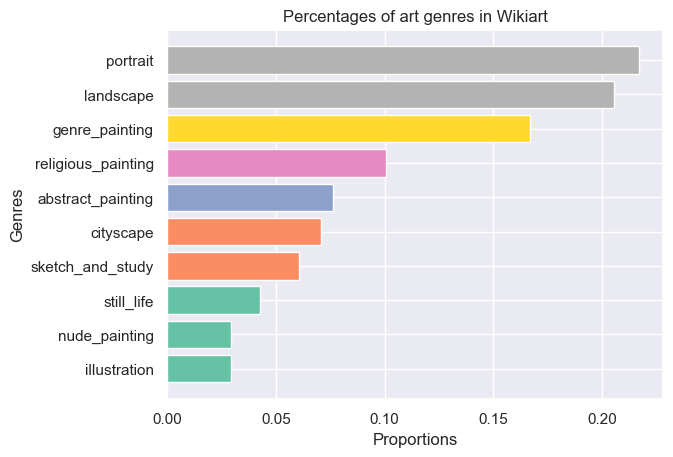

In [42]:
# Plot the proportions of genres
data = pd.DataFrame({'Genre':['abstract_painting','cityscape','genre_painting','illustration','landscape','nude_painting','portrait','religious_painting','sketch_and_study','still_life'],
                     'Proportion': [0.076437, 0.070821, 0.167074, 0.029264, 0.205524, 0.029587, 0.21714, 0.100592, 0.060666, 0.042896]
                    })
    
data = data.sort_values('Proportion', ascending=True)
norm = plt.Normalize(data.Proportion.min(), data.Proportion.max())
colors = plt.cm.Set2(norm(data.Proportion))
ax = plt.barh(data.Genre, data.Proportion, color = colors)
plt.title('Percentages of art genres in Wikiart')
plt.xlabel("Proportions")
plt.ylabel("Genres")
plt.show()



In [31]:
df_with_genre.groupby('art_style').describe()['emotion_label']['count'] / len(df_with_genre)


art_style
Abstract_Expressionism        0.036579
Action_painting               0.001781
Analytical_Cubism             0.001701
Art_Nouveau_Modern            0.039613
Baroque                       0.051196
Color_Field_Painting          0.025145
Contemporary_Realism          0.006550
Cubism                        0.024193
Early_Renaissance             0.019851
Expressionism                 0.078355
Fauvism                       0.008635
High_Renaissance              0.017093
Impressionism                 0.178883
Mannerism_Late_Renaissance    0.015389
Minimalism                    0.013307
Naive_Art_Primitivism         0.026918
New_Realism                   0.004636
Northern_Renaissance          0.033605
Pointillism                   0.007094
Pop_Art                       0.008701
Post_Impressionism            0.086060
Realism                       0.144030
Rococo                        0.026182
Romanticism                   0.082404
Symbolism                     0.045963
Synthetic_Cubis

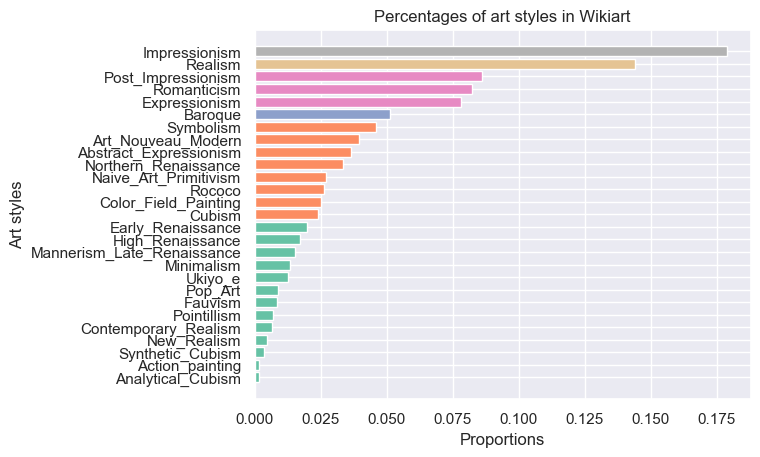

In [40]:
# Plot the proportions of art styles
data = pd.DataFrame({'Art_style':['Abstract_Expressionism','Action_painting','Analytical_Cubism','Art_Nouveau_Modern','Baroque','Color_Field_Painting','Contemporary_Realism','Cubism','Early_Renaissance','Expressionism', 'Fauvism', 'High_Renaissance', 'Impressionism', 'Mannerism_Late_Renaissance', 'Minimalism', 'Naive_Art_Primitivism', 'New_Realism', 'Northern_Renaissance', 'Pointillism', 'Pop_Art', 'Post_Impressionism', 'Realism', 'Rococo', 'Romanticism', 'Symbolism', 'Synthetic_Cubism', 'Ukiyo_e'],
                     'Proportion': [0.036579, 0.001781, 0.001701, 0.039613, 0.051196, 0.025145, 0.006550, 0.024193, 0.019851, 0.078355, 0.008635, 0.017093, 0.178883, 0.015389, 0.013307, 0.026918, 0.004636, 0.033605, 0.007094, 0.008701, 0.086060, 0.144030, 0.026182, 0.082404, 0.045963, 0.003535, 0.012601]
                    })

data = data.sort_values('Proportion', ascending=True)
norm = plt.Normalize(data.Proportion.min(), data.Proportion.max())
colors = plt.cm.Set2(norm(data.Proportion))
ax = plt.barh(data.Art_style, data.Proportion, color = colors)
plt.title('Percentages of art styles in Wikiart')
plt.xlabel("Proportions")
plt.ylabel("Art styles")
plt.show()

Romanticism jan-matejko_konrad-i-of-masovia


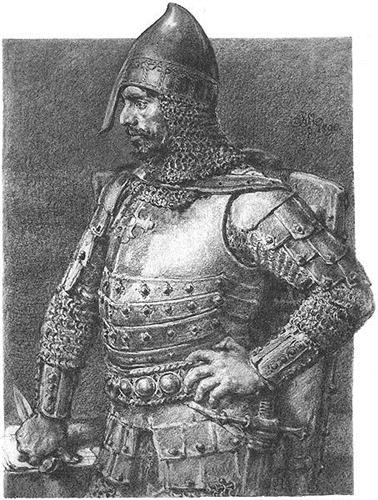

AWE:	The man is dressed in full armor with a straight posture stance indicating confidence and inspiring awe.
AWE:	The shiny metallic armor looks very strong and makes the man look invulnerable
SADNESS:	This feels gloomy because of the grey colors. Looks like he is off to battle and possibly death.
FEAR:	This armored knight looks as if they have some fear for the quest ahead.
EXCITEMENT:	This guy looks like a badass who probably has some interesting adventures.


In [181]:
# Show captions for a random portait.
sb = df_with_genre[df_with_genre.genre == 'portrait']
show_random_captions(sb, wikiart_img_dir)

In [71]:
# Check the emotional distribution for 1000 images with the original proportion as artemis
df['emotion'].value_counts()/df.shape[0]*1000

contentment       277.410245
awe               160.390513
something else    116.480897
sadness           107.901312
amusement          99.708809
fear               91.441529
excitement         82.773970
disgust            49.289177
anger              14.603549
Name: emotion, dtype: float64

In [72]:
# Create the 3-cols df for 'concrete' paintings
emo_domi_df = pd.read_csv('/Users/Cherry0904/Desktop/full_df_with_emo_domi.csv')
emo_domi_df = emo_domi_df[['painting', 'domi_emotion', 'utterance_combined']]
emo_domi_df.shape


(36534, 3)

In [74]:
emo_domi_df['domi_emotion'].value_counts()

contentment       17143
awe                5204
sadness            3845
fear               3324
amusement          2851
something else     2157
excitement         1335
disgust             627
anger                48
Name: domi_emotion, dtype: int64

In [75]:
equal_emo_domi_df = emo_domi_df.groupby('domi_emotion').apply(lambda df: df.sample(48))
equal_emo_domi_df['domi_emotion'].value_counts()

amusement         48
anger             48
awe               48
contentment       48
disgust           48
excitement        48
fear              48
sadness           48
something else    48
Name: domi_emotion, dtype: int64

### Subset dataset with the same emotion distribution as the original ArtEmis

In [201]:
# Load the full dataset with emo_domi
df = pd.read_csv("/Users/Cherry0904/Desktop/df_with_emo_domi/full_df_with_emo_domi.csv")
del df['Unnamed: 0']
df.columns

Index(['art_style', 'painting', 'emotion', 'utterance', 'has_emo_domi',
       'domi_emotion', 'utterance_for_domi_emo', 'utterance_combined'],
      dtype='object')

In [164]:
df.shape

(36534, 8)

In [132]:
df['domi_emotion'].value_counts()

contentment       17143
awe                5204
sadness            3845
fear               3324
amusement          2851
something else     2157
excitement         1335
disgust             627
anger                48
Name: domi_emotion, dtype: int64

In [285]:
artemis_preprocessed_csv = '/Users/Cherry0904/Desktop/official_data/artemis_preprocessed.csv'
all_df = pd.read_csv(artemis_preprocessed_csv)
all_df.shape
# all_df['emotion'].value_counts()
# all_df['emotion'].value_counts()/all_df.shape[0]

(454684, 11)

In [143]:
full_emo_domi_csv = '/Users/Cherry0904/Desktop/df_with_emo_domi/full_df_with_emo_domi.csv'
full_df = pd.read_csv(full_emo_domi_csv)
full_df = full_df[['art_style', 'painting']]


In [139]:
df_2000_csv = '/Users/Cherry0904/Desktop/subsets_for_modelling/subset_mi_test_2000/subset_2000_balanced.csv'
df_2000 = pd.read_csv(df_2000_csv)
df_2000.shape

(2000, 3)

In [113]:
df_2000.domi_emotion.unique()

array(['amusement', 'disgust', 'fear', 'something else', 'excitement',
       'contentment', 'anger', 'awe', 'sadness'], dtype=object)

In [142]:
df_2000_no_cont = df_2000[df_2000["domi_emotion"].isin(['disgust', 'fear', 'something else', 'anger','sadness','amusement', 'excitement', 'awe'])]
print(df_2000_no_cont.domi_emotion.unique())
print(df_2000_no_cont.shape)
df_2000_no_cont.to_csv('/Users/Cherry0904/Desktop/no_cont_subset_2000_balanced.csv', index = False, sep=',', encoding='utf-8')

['amusement' 'disgust' 'fear' 'something else' 'excitement' 'anger' 'awe'
 'sadness']
(1445, 3)


In [114]:
df_2000_p = df_2000[df_2000["domi_emotion"].isin(['amusement', 'excitement', 'contentment', 'awe'])]
df_2000_p.domi_emotion.unique()

array(['amusement', 'excitement', 'contentment', 'awe'], dtype=object)

In [116]:
df_2000_p.shape
df_2000_p.to_csv('/Users/Cherry0904/Desktop/positive_subset_2000_balanced.csv', index = False, sep=',', encoding='utf-8')

In [5]:
df_2000 = df_2000.drop(df_2000[df_2000.domi_emotion == "something else"].index)
df_2000.shape

(1768, 3)

In [10]:
df_2000['domi_emotion'] = df_2000['domi_emotion'].map({'amusement': 'positive', 'contentment': 'positive', 'excitement': 'positive', 'awe': 'positive',
                                                       'fear': 'negative', 'disgust': 'negative', 'sadness': 'negative', 'anger': 'negative'})
df_2000.domi_emotion.unique()

array(['positive', 'negative'], dtype=object)

In [11]:
df_2000.to_csv('/Users/Cherry0904/Desktop/pn_subset_2000_balanced.csv', index = False, sep=',', encoding='utf-8')

In [145]:
new_df = pd.merge(df_2000_no_cont, full_df, on = 'painting', how = 'left')
new_df.shape

(1445, 4)

In [146]:
new_df.to_csv('/Users/Cherry0904/Desktop/no_cont_subset_1445_with_artstyle.csv', sep=',', encoding='utf-8')

In [263]:
all_df.columns

Index(['art_style', 'painting', 'emotion', 'utterance', 'repetition', 'split',
       'tokens', 'tokens_len', 'utterance_spelled', 'tokens_encoded',
       'emotion_label'],
      dtype='object')

In [197]:
# Check the shannon entrophy for the entire artemis dataset 
list_of_counts = [126134, 72927, 52962, 49061, 45336, 41577, 37636, 22411, 6640]
list_of_probs = [i/all_df.shape[0] for i in list_of_counts]
total_count = sum(list_of_counts)
shannon_entropy = -(sum([c/total_count * np.log(c/total_count) for c in list_of_counts]))/np.log(9)
print(shannon_entropy)


0.9124567956435299


In [198]:
# Get the numbers to keep for 1000 datapoints
list_of_right_numbers = [i*2500 for i in list_of_probs]
print(list_of_right_numbers)

[693.5256133930378, 400.9762824291156, 291.2022415567735, 269.75327920049966, 249.2720218877286, 228.60382155519, 206.93492623448373, 123.22294164738588, 36.50887209578521]


In [202]:
# Drop the rows of labels to make them have the right proportions 
import random
import collections


def drop_rows_for_a_label(df, label_string, total_num, num_to_keep):
    list = df[df.domi_emotion == label_string].index.tolist()
    sampled_list = random.sample(list, total_num-num_to_keep)
    df.drop(sampled_list, axis=0, inplace=True)

    return df

df = drop_rows_for_a_label(df, 'contentment', 17143, 693)
df = drop_rows_for_a_label(df, 'awe', 5204, 401)
df = drop_rows_for_a_label(df, 'something else', 2157, 291)
df = drop_rows_for_a_label(df, 'sadness', 3845, 270)
df = drop_rows_for_a_label(df, 'amusement', 2851, 249)
df = drop_rows_for_a_label(df, 'fear', 3324, 229)
df = drop_rows_for_a_label(df, 'excitement', 1335, 207)
df = drop_rows_for_a_label(df, 'disgust', 627, 123)
df = drop_rows_for_a_label(df, 'anger', 48, 37)


df.shape

(2500, 8)

In [203]:
df = df[['painting', 'domi_emotion', 'utterance_combined']]
df.shape
df.to_csv('/Users/Cherry0904/Desktop/subset_2500_balanced.csv', sep=',', encoding='utf-8', index=False)

In [183]:
df.groupby('pne')['emotion'].count() / len(df)

pne
0    0.620284
1    0.263236
2    0.116481
Name: emotion, dtype: float64

In [184]:
## Quick analysis on emotions and subjectivity.  (this can take up to a minute!)
has_pos_feels = grouped_artwork.apply(lambda group: 0 in group.pne.unique())
has_neg_feels = grouped_artwork.apply(lambda group: 1 in group.pne.unique())
has_else_feels = grouped_artwork.apply(lambda group: 2 in group.pne.unique())

c1 = (has_pos_feels & has_neg_feels)
c2 = (has_pos_feels & has_else_feels)
c3 = (has_neg_feels & has_else_feels)

stat1 = (c1).mean().round(2)
stat2 = (c1|c2|c3).mean().round(2)

print('Percent of artworks annotated with emotions that are POS _and_ NEG', stat1)
print('Percent of artworks annotated with emotions that are ELSE&NEG or ELSE&POS or NEG&POS', stat2)

Percent of artworks annotated with emotions that are POS _and_ NEG 0.61
Percent of artworks annotated with emotions that are ELSE&NEG or ELSE&POS or NEG&POS 0.79


In [ ]:
# Create the dataframe with paintings that have emotional dominance
df_csv = '/Users/Cherry0904/Desktop/official_data/artemis_dataset_release_v0.csv'
df = pd.read_csv(df_csv)
df['utterance'] = df['utterance'].apply(lambda x: add_full_stop(x))

# Add full stop to the end of an utterance if there is no full stop
def add_full_stop(sentence):
    sentence = sentence.capitalize() # Capitalise the first letter of each utterance
    if sentence[-1] not in ['.', '!', '?']:
        sentence = sentence + "."
    return sentence

# Return the list of utterance that corresponds to the dominant emotion
def return_utterance_list_for_domi_emo(utterance_list, emotion_list, domi_emotion):
    utterance_list_for_domi_emo = []
    for i in range(len(emotion_list)):
        if emotion_list[i] == domi_emotion:
            utterance_list_for_domi_emo.append(utterance_list[i])
    return utterance_list_for_domi_emo

new_df = (df.groupby(['art_style', 'painting'],as_index=False)
           .agg(list)
           .reindex(columns=df.columns))
new_df = new_df[['art_style', 'painting', 'emotion', 'utterance']]

new_df['has_emo_domi'] = new_df['emotion'].apply(lambda x: has_emotion_max_dominance_for_list(x))
new_df['domi_emotion'] = new_df['emotion'].apply(lambda x: has_emotion_max_dominance_for_list(x, return_max=True))

# Remove paintings with no emo_domi
emo_domi_df = new_df.copy()
emo_domi_df = emo_domi_df.loc[emo_domi_df['has_emo_domi'] == True]
emo_domi_df.shape # (36534, 6)

# Create a new column of list of utterances that correspond to the dominant emotion
emo_domi_df['utterance_for_domi_emo'] = emo_domi_df.apply(lambda x: return_utterance_list_for_domi_emo(x.utterance, x.emotion, x.domi_emotion), axis=1)

# Combine the utterances of one painting into one string
emo_domi_df['utterance_combined'] = emo_domi_df['utterance_for_domi_emo'].apply(lambda x: ''.join(x))

emo_domi_df.to_csv('/Users/Cherry0904/Desktop/full_df_with_emo_domi.csv', sep=',', encoding='utf-8')

In [43]:
#
# Majority-dominance in emotions (this can take up to a minute!)
#

# Find artworks where one emotion was indicated by
# at least half the annotators of that artwork.
emo_domi = grouped_artwork.apply(has_emotion_max_dominance)
emo_domi.mean(), emo_domi.sum()

(0.45649810698354387, 36534)

In [ ]:
print(emo_domi)

art_style               painting                                                             
Abstract_Expressionism  aaron-siskind_acolman-1-1955                                             False
                        aaron-siskind_chicago-1951                                               False
                        aaron-siskind_chicago-6-1961                                              True
                        aaron-siskind_feet-102-1957                                              False
                        aaron-siskind_gloucester-16a-1944                                         True
                                                                                                 ...  
Ukiyo_e                 utagawa-toyokuni_the-actor-otani-monzo-in-the-role-of-igarashi-tenzen    False
                        utagawa-toyokuni_the-heian-courtier                                      False
                        utagawa-toyokuni_the-promenade                            

<Figure size 640x480 with 0 Axes>

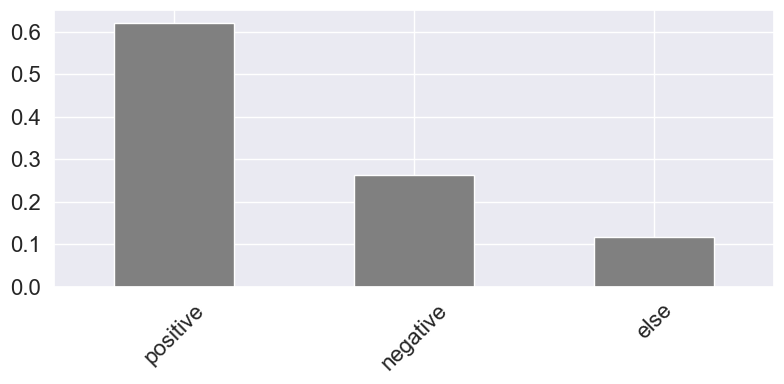

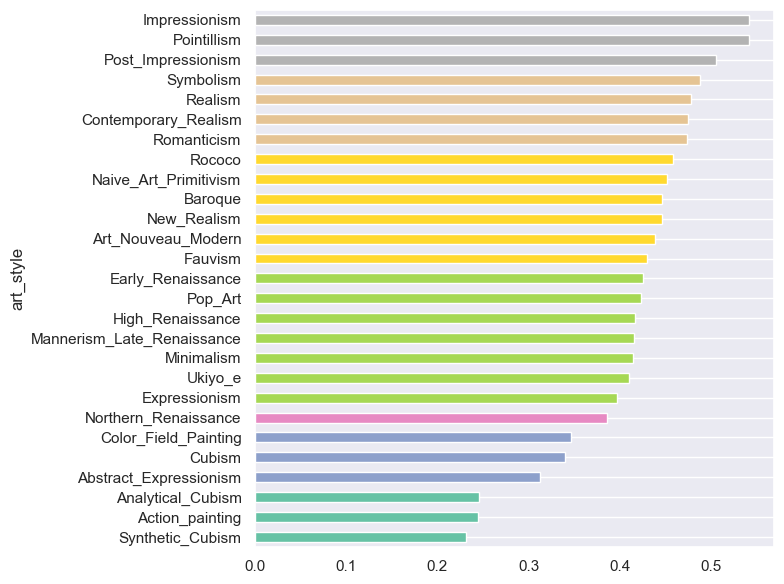

[0.         0.04328159 0.04507714 0.26144086 0.34880337 0.368849
 0.49809757 0.53275168 0.57637272 0.59097642 0.5910972  0.59660536
 0.61716702 0.62353637 0.63766099 0.66537138 0.69158519 0.69234622
 0.7078935  0.73098732 0.77905844 0.78240555 0.79586243 0.82623071
 0.88358547 0.99855788 1.        ]


In [44]:
# Plot majority-dominance of emotions per art-style.
s = emo_domi.groupby('art_style').mean().sort_values()
norm = plt.Normalize(s.min(), s.max())
colors = plt.cm.Set2(norm(s.values))
fig = plt.figure(figsize=(8, 6))
ax = s.plot.barh(color=colors)
ax.xaxis.grid() # horizontal lines
plt.tight_layout()
plt.show()

if save_figs:
    fig.savefig('emotional_majority_agreement_per_art_style.jpg')

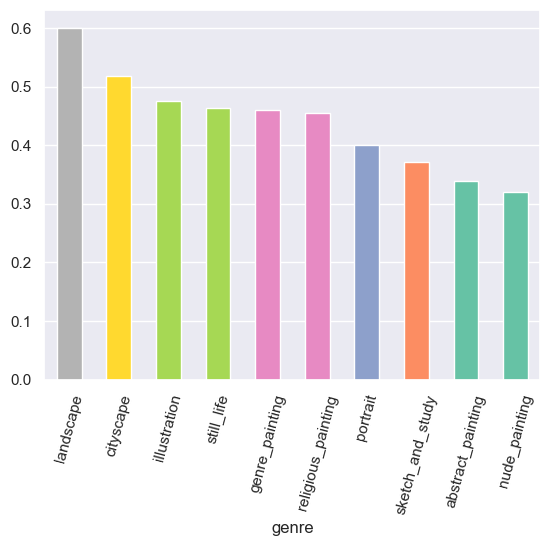

In [158]:
##
## Plot majority-dominance in emotions, per genre.
## 
# (recall - not all artworks have "genre" labels. working here with those that do.)

emo_domi.name = 'majority-agreement'
temp = pd.merge(emo_domi, genre_info, on=['art_style', 'painting'])
s = temp.groupby('genre').mean().sort_values('majority-agreement', ascending = False)
s = s['majority-agreement']
norm = plt.Normalize(s.min(), s.max())
colors = plt.cm.Set2(norm(s.values))
fig = plt.figure()
ax = s.plot.bar(color=colors, grid=True, rot=75)
ax.xaxis.grid() # horizontal lines
plt.show()

if save_figs:
    fig.savefig('emotional_majority_agreement_per_genre.jpg')

In [90]:
# also now note the emotion that is the dominant (so we can count it per 1 of 9 "emotion" choices)
foo = partial(has_emotion_max_dominance, return_max=True)
emo_domi = grouped_artwork.apply(foo)
has_emo_domi = pd.Series([x[1] for x in emo_domi.values if x[0] == True]) # keeps only paintings where emo-dominance exists

# print the percentages (unnormalized and normalized per emotion)
raw_emo_cnt = df.emotion.value_counts().to_dict()
emo_domi_cnt = has_emo_domi.value_counts().to_dict()
for emo in ARTEMIS_EMOTIONS:
    print("{:15}{:8}{:15.4f}".format(emo, emo_domi_cnt[emo], emo_domi_cnt[emo] / raw_emo_cnt[emo]))

amusement          2851         0.0629
awe                5204         0.0714
contentment       17143         0.1359
excitement         1335         0.0355
anger                48         0.0072
disgust             627         0.0280
fear               3324         0.0799
sadness            3845         0.0784
something else     2157         0.0407


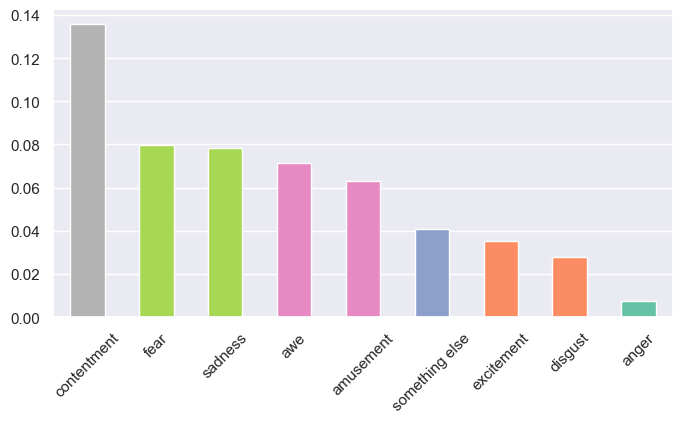

In [204]:
##
## Plot the percentage of majority-dominance for each of the nine emotion category.
## 

s = has_emo_domi.value_counts()/df.emotion.value_counts()
s = s.sort_values(ascending=False)
norm = plt.Normalize(s.min(), s.max())
colors = plt.cm.Set2(norm(s.values))
fig = plt.figure()
ax = s.plot.bar(grid=True, figsize=(8,4), fontsize=11, rot=45, legend=False, color=colors)
ax.xaxis.grid() # horizontal lines
plt.show()


0    0.094078
1    0.065537
2    0.040727
Name: pne, dtype: float64


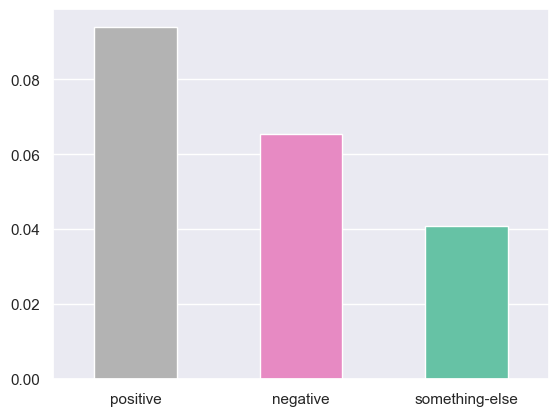

In [178]:
##
## Plot the percentage of majority-dominance for each emotion category - positive, negative, else.
## 
pne_list= [sum(has_emo_domi.value_counts()[i] for i in [0,1,4,6]),
           sum(has_emo_domi.value_counts()[i] for i in [2,3,7,8]),
           has_emo_domi.value_counts()[5]]

s = pne_list/df.pne.value_counts()
print(s)
s = s.sort_values(ascending=False)
norm = plt.Normalize(s.min(), s.max())
colors = plt.cm.Set2(norm(s.values))
fig = plt.figure()
ax = s.plot.bar(color=colors, grid=True, rot=0)
ax.set_xticklabels(['positive', 'negative', 'something-else'])
ax.xaxis.grid() # horizontal lines
plt.show()

In [91]:
is_met = df.utterance_spelled.apply(lambda x: sum([i in x for i in metaphorical_substrings]) >= 1)
print('Percent of annotations making a simile (approximate)', is_met.mean())

print('\nSamples:')
ds = df[is_met].sample(5)
for u in ds.utterance:
    print(u)

Percent of annotations making a simile (approximate) 0.2090770733080557

Samples:
this naked lady makes m think of sex and that is exciting
The children dancing in a meadow of flowers reminds me of paradise.
The colors are bright and cheerful.  It looks like a really pretty day.
the lingering tree branches look like creepy long fingers
very simple, but the hillside looks like a deflated frog, and that makes me laugh


In [185]:
pedantic = True

if pedantic:
    print('Token Length per genre/art_style\n')
    print(df_with_genre.groupby('genre')['tokens_len'].mean().sort_values())
    print(df.groupby('art_style')['tokens_len'].mean().sort_values())

    # plot the histograms of token lengths for abstract_painting and genre_painting  
    # fig, ax = plt.subplots()
    # ax2 = ax.twiny()
    # df_with_genre[df_with_genre['genre'] == 'abstract_painting']['tokens_len'].hist(bins=100, ax=ax, color='red')
    # df_with_genre[df_with_genre['genre'] == 'genre_painting']['tokens_len'].hist(bins=100, ax=ax2, color='green', alpha=0.3)

Token Length per genre/art_style

genre
abstract_painting     15.338144
still_life            15.486418
sketch_and_study      15.584676
landscape             15.657401
nude_painting         15.662590
portrait              15.850005
cityscape             15.962521
religious_painting    16.249924
illustration          16.377809
genre_painting        16.460087
Name: tokens_len, dtype: float64
art_style
Pointillism                   13.734843
Analytical_Cubism             13.856911
Synthetic_Cubism              14.105140
Action_painting               14.219880
Fauvism                       14.466237
Contemporary_Realism          14.673891
Minimalism                    15.006980
Color_Field_Painting          15.066897
Ukiyo_e                       15.081784
New_Realism                   15.208874
Mannerism_Late_Renaissance    15.452249
Early_Renaissance             15.459722
High_Renaissance              15.538284
Pop_Art                       15.658450
Abstract_Expressionism        15.6718

Number of tokens per utterance (punctuations removed), for utterances with at most 50 tokens (99.34% of all utterances).


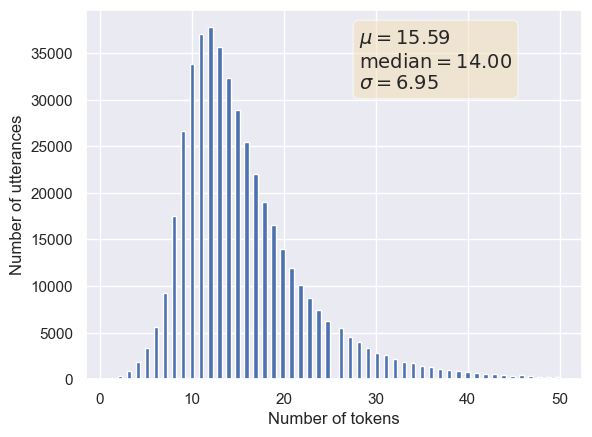

In [187]:
tokens_len = df.tokens_len[df.tokens_len <= 50]
print("Number of tokens per utterance (punctuations removed), for utterances with at most 50 tokens ({:.2f}% of all utterances).".format((df.tokens_len <= 50).mean() * 100))

mu = tokens_len.mean()
median = tokens_len.median()
sigma = tokens_len.std()
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))

ax = tokens_len.hist(bins=100)

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.55, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.xlabel('Number of tokens', fontsize=12)
plt.ylabel('Number of utterances', fontsize=12)
plt.show()

In [188]:
def rough_fine_grained_emotion_analysis_of_something_else(tokens):
    found_counter = 0
    fine_grained_emotion_category = None
    for t in tokens:        
        for f in LARGER_EMOTION_VOCAB:
            if t in f:
                found_counter += 1
                fine_grained_emotion_category = f[0]
    
    if found_counter == 1: # found_exactly_one
        return fine_grained_emotion_category
    else:
        return 'unclassified'

n_se = (df.emotion == 'something else').sum()
print('annotations with something-else choice:', n_se)

annotations with something-else choice: 52962


In [189]:
se = df[df.emotion == 'something else']
fg_se_emo = se['tokens'].apply(rough_fine_grained_emotion_analysis_of_something_else)
print('These emotion-words or synonyms are found exactly once in these many "something else" annotations:')
print(fg_se_emo.value_counts())

These emotion-words or synonyms are found exactly once in these many "something else" annotations:
unclassified      36836
confused           5333
bored              3904
curious            3889
happy               690
uncomfortable       371
anxiety             310
nostalgia           309
hope                295
neutral             285
creepy              277
depressing          136
overwhelmed          76
bothered             56
anticipation         49
shock                36
disappointment       31
shame                17
shy                  15
surprised            12
alerted              11
rage                  6
thrilled              4
empowerment           4
grief                 4
insult                3
exhilarating          3
Name: tokens, dtype: int64


In [190]:
def pne(group):
    "return number of positive:0, negative:1, and som-else:2 in a group"
    p = sum(group == 0)
    n = sum(group == 1)
    e = sum(group == 2)    
    return p, n, e

def pne_distribution_plot(pne_of_stim, grouping_col):
    new_stats = []
    for n, g in pne_of_stim.groupby(grouping_col):
        tc = sum([np.array(x) for x in g.values])
        tc = [i /sum(tc) for i in tc]
        new_stats.append([n, tc])

    ns = pd.DataFrame.from_dict(dict(new_stats)).T
    ns = ns.rename(columns={0:'pos', 1:'neg', 2:'else'})
    ns = ns.sort_values(by='pos')

    title = 'Emotion Distribution: Positive vs. Negative vs. Something-else'

    kw = {'figsize': (6, 6), 
          'fontsize': 12,
          'grid': True,
          'title': title}

    
    ns['pos'].plot(kind='barh', color='#008B00', **kw)
    ns['neg'].plot(kind='barh', left=ns['pos'], color='#DC143C')
    ns['else'].plot(kind='barh', left=ns['pos']+ns['neg'], color='#6E7B8B')

    plt.ylabel(grouping_col)
    plt.show()
    
    if save_figs:
        plt.savefig('pos_neg_else_distribution_per_{}.jpg'.format(grouping_col))
    
    return plt.tight_layout()

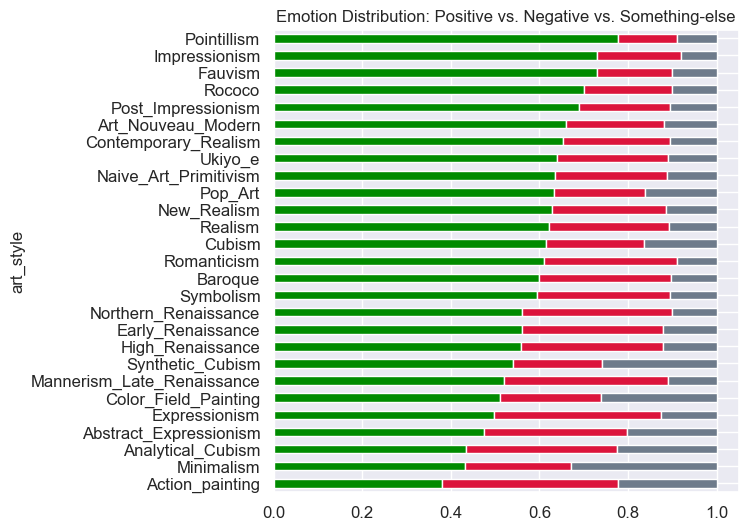

In [191]:
## Plot pos-vs-neg-vs-else as mass per art_style
grouping_col = 'art_style'
stimuli = df.groupby([grouping_col])
pne_of_stim = stimuli.pne.apply(pne)
pne_distribution_plot(pne_of_stim, grouping_col)

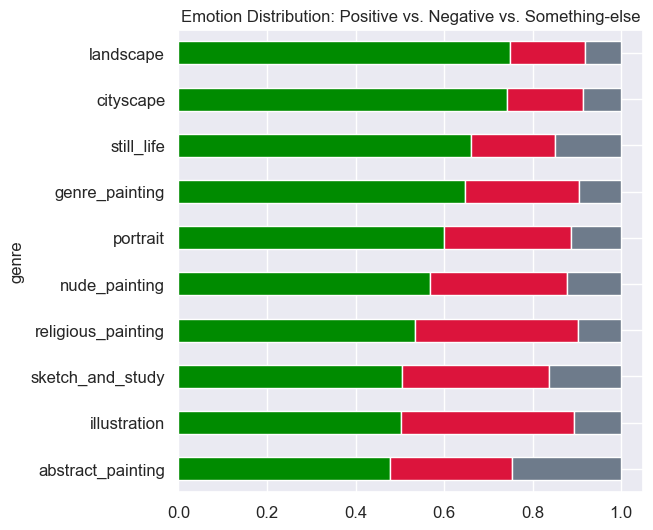

In [192]:
## Plot pos-vs-neg-vs-else as mass per genre
grouping_col = 'genre'
stimuli = df_with_genre.groupby([grouping_col])
pne_of_stim = stimuli.pne.apply(pne)
pne_distribution_plot(pne_of_stim, grouping_col)

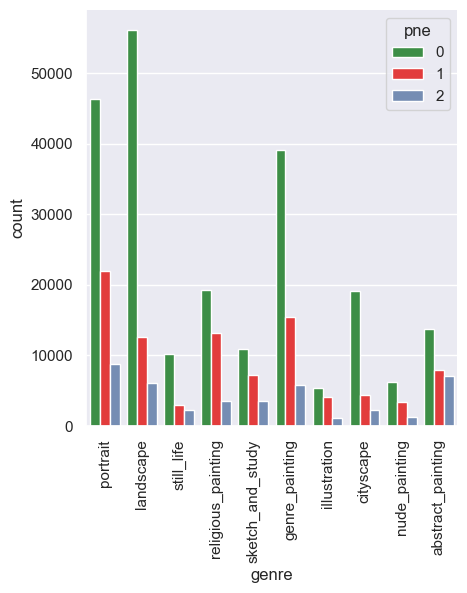

In [196]:
#
# plot pos-neg-else histogram per genre. 
# Note. Abstract paintings get most "2" (somethin-else) per proportion of their size.
#       Landscapes the most positive emotions "0".

c = sns.catplot(x="genre", 
                hue="pne", 
                data=df_with_genre, 
                kind="count",                 
                palette={1: "#FE2020", 
                         0: "#2f9c3b", 
                         2: "#6b8abd"},                                
                legend_out=False)

c.set_xticklabels(rotation=90)
plt.show()

In [197]:
## see the normalized statistics of the above plot.
x, y = 'genre', 'pne'
df1 = df_with_genre.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1

genre               pne
abstract_painting   0      47.776194
                    1      27.638488
                    2      24.585318
cityscape           0      74.203958
                    1      17.110532
                    2       8.685510
genre_painting      0      64.751085
                    1      25.674870
                    2       9.574045
illustration        0      50.324401
                    1      38.975082
                    2      10.700517
landscape           0      74.976635
                    1      16.898983
                    2       8.124382
nude_painting       0      56.832812
                    1      30.991356
                    2      12.175832
portrait            0      60.047404
                    1      28.534238
                    2      11.418358
religious_painting  0      53.482359
                    1      36.819863
                    2       9.697779
sketch_and_study    0      50.446634
                    1      33.193664
              

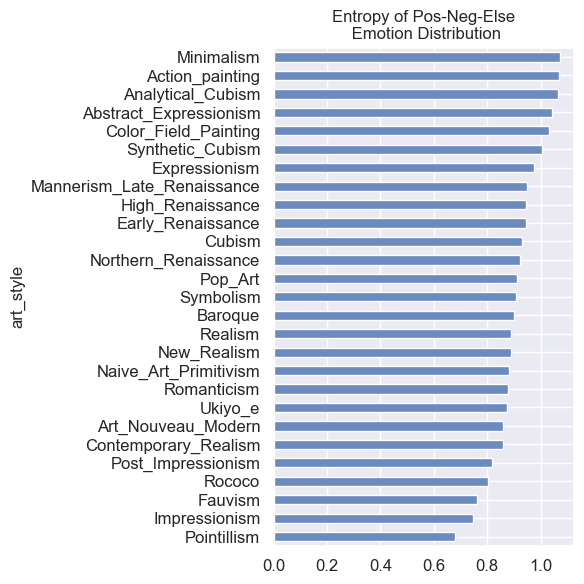

In [199]:
#
# plot the entropy of the pos-neg-else (ternary) distribution per art_style
#
grouping_col = 'art_style'
stimuli = df.groupby([grouping_col])
pne_of_stim = stimuli.pne.apply(pne)


pne_of_stim.apply(entropy).groupby(grouping_col).mean().sort_values().plot(kind='barh', 
                                                                          figsize=(6, 6), 
                                                                          fontsize=12,
                                                                          grid=True,
                                                                          title='Entropy of Pos-Neg-Else\n Emotion Distribution',
                                                                          color='#6b8abd')
plt.tight_layout()
plt.show()

if save_figs:
    plt.savefig('pos_neg_else_distribution_entropy_per_art_style.jpg')

### Subset data with emotional dominance

In [ ]:
# Create the dataframe with paintings that have emotional dominance

# Add full stop to the end of an utterance if there is no full stop
def add_full_stop(sentence):
    sentence = sentence.capitalize() # Capitalise the first letter of each utterance
    if sentence[-1] not in ['.', '!', '?']:
        sentence = sentence + "."
    return sentence

# Return the list of utterance that corresponds to the dominant emotion
def return_utterance_list_for_domi_emo(utterance_list, emotion_list, domi_emotion):
    utterance_list_for_domi_emo = []
    for i in range(len(emotion_list)):
        if emotion_list[i] == domi_emotion:
            utterance_list_for_domi_emo.append(utterance_list[i])
    return utterance_list_for_domi_emo

df_csv = '/Users/Cherry0904/Desktop/official_data/artemis_dataset_release_v0.csv'
df = pd.read_csv(df_csv)
df['utterance'] = df['utterance'].apply(lambda x: add_full_stop(x))

new_df = (df.groupby(['art_style', 'painting'],as_index=False)
           .agg(list)
           .reindex(columns=df.columns))
new_df = new_df[['art_style', 'painting', 'emotion', 'utterance']]

new_df['has_emo_domi'] = new_df['emotion'].apply(lambda x: has_emotion_max_dominance_for_list(x))
new_df['domi_emotion'] = new_df['emotion'].apply(lambda x: has_emotion_max_dominance_for_list(x, return_max=True))

# Remove paintings with no emo_domi
emo_domi_df = new_df.copy()
emo_domi_df = emo_domi_df.loc[emo_domi_df['has_emo_domi'] == True]
emo_domi_df.shape # (36534, 6)

# Create a new column of list of utterances that correspond to the dominant emotion
emo_domi_df['utterance_for_domi_emo'] = emo_domi_df.apply(lambda x: return_utterance_list_for_domi_emo(x.utterance, x.emotion, x.domi_emotion), axis=1)

# Combine the utterances of one painting into one string
emo_domi_df['utterance_combined'] = emo_domi_df['utterance_for_domi_emo'].apply(lambda x: ''.join(x))

emo_domi_df.to_csv('/Users/Cherry0904/Desktop/full_df_with_emo_domi.csv', sep=',', encoding='utf-8')


In [61]:
# Create the 3-cols df for 'concrete' paintings
emo_domi_df = pd.read_csv('/Users/Cherry0904/Desktop/full_df_with_emo_domi.csv')
emo_domi_df_concrete = emo_domi_df.loc[emo_domi_df['art_style'].isin(['Impressionism', 'Pointillism', 'New_Realism', 'Contemporary_Realism'])]
emo_domi_df_concrete = emo_domi_df_concrete[['painting', 'domi_emotion', 'utterance_combined']]
emo_domi_df_concrete.shape
emo_domi_df_concrete.to_csv('/Users/Cherry0904/Desktop/concrete_df_emo_domi_ipnc.csv', index=False, sep=',', encoding='utf-8')

In [69]:
emo_domi_df_concrete.shape # Number of 'concrete' paintings with emo_dominance

(1601, 3)

In [20]:
# Create the 3-cols df for all paintings with negative dominant emotions
emo_domi_df_positive = emo_domi_df.loc[emo_domi_df['domi_emotion'].isin(['amusement', 'awe', 'contentment', 'excitement'])]
emo_domi_df_positive = emo_domi_df_positive[['painting', 'domi_emotion', 'utterance_combined']]
emo_domi_df_positive.shape

(26533, 3)

In [19]:
# Create the 3-cols df for all paintings with negative dominant emotions
emo_domi_df_negative = emo_domi_df.loc[emo_domi_df['domi_emotion'].isin(['anger', 'disgust', 'fear', 'sadness', 'something else'])]
emo_domi_df_negative = emo_domi_df_negative[['painting', 'domi_emotion', 'utterance_combined']]
emo_domi_df_negative.shape

(10001, 3)

In [71]:
# Count the number of 'concrete' paintings
new_df_concrete = new_df.loc[new_df['art_style'].isin(['Rococo','Pointillism', 'New_Realism', 'Contemporary_Realism'])]
new_df_concrete.shape

(3394, 6)

In [97]:
# Create the 3-cols df for 'abstract' paintings
emo_domi_df_abstract = emo_domi_df.loc[emo_domi_df['art_style'].isin(['Minimalism', 'Analytical_Cubism', 'Action Painting'])]
emo_domi_df_abstract.shape
emo_domi_df_abstract = emo_domi_df_abstract[['painting', 'domi_emotion', 'utterance_combined']]
emo_domi_df_abstract.to_csv('/Users/Cherry0904/Desktop/abstract_df_emo_domi.csv', index=False, sep=',', encoding='utf-8')

In [86]:
# Count the number of 'abstract' paintings
new_df_abstract = new_df.loc[new_df['art_style'].isin(['Minimalism', 'Analytical_Cubism', 'Action Painting'])]
new_df_abstract.shape

(1364, 6)

In [121]:
# Experiment with appending binary image features to the concept matrix
img_features_df_csv = '/Users/Cherry0904/Desktop/data_with_img_features/concise_binary_df.csv'
img_features_df = pd.read_csv(img_features_df_csv)
img_features_df = img_features_df[['art_style', 'painting', 'binary_feature_vector']]
img_features_df.columns

Index(['art_style', 'painting', 'binary_feature_vector'], dtype='object')

In [122]:
# Create a df that contains only the binary image features for each unique painting
new_img_features_df = (img_features_df.groupby(['art_style', 'painting'],as_index=False)
           .agg(list)
           .reindex(columns=img_features_df.columns))
new_img_features_df = new_img_features_df[['painting', 'binary_feature_vector']]
new_img_features_df.rename(columns = {'painting':'id'}, inplace = True)
new_img_features_df['binary_feature_vector'] = new_img_features_df['binary_feature_vector'].apply(lambda x: x[0]) # Choose the first element in the list, still a string
new_img_features_df['binary_feature_vector'] = new_img_features_df['binary_feature_vector'].apply(literal_eval) # Turn the string into a list (not array)
new_img_features_df.to_csv('/Users/Cherry0904/Desktop/binary_img_features_each_image.csv', index=False, sep=',', encoding='utf-8')

In [90]:
concrete_df_csv = '/Users/Cherry0904/Desktop/concrete_df_emo_domi_pnc_balanced.csv'
concrete_df = pd.read_csv(concrete_df_csv)
concrete_df.shape

(225, 3)

In [359]:
df_1500_csv = '/Users/Cherry0904/Desktop/subset_1500_with_artstyle.csv'
df_1500 = pd.read_csv(df_1500_csv)

df_1500['art_style'].value_counts() 

Impressionism                 252
Realism                       156
Romanticism                   131
Post_Impressionism            116
Expressionism                 112
Art_Nouveau_Modern             92
Baroque                        84
Symbolism                      81
Abstract_Expressionism         54
Northern_Renaissance           54
Naive_Art_Primitivism          46
Rococo                         42
Minimalism                     42
Color_Field_Painting           41
Pop_Art                        36
Cubism                         34
High_Renaissance               27
Ukiyo_e                        20
Early_Renaissance              18
Mannerism_Late_Renaissance     16
Fauvism                        14
Pointillism                    11
New_Realism                     8
Contemporary_Realism            5
Synthetic_Cubism                5
Analytical_Cubism               3
Name: art_style, dtype: int64

In [ ]:
# df_2000_pn = pd.read_csv('/Users/Cherry0904/Desktop/pn_subset_1761_with_artstyle.csv')
# df_2000_p = pd.read_csv('/Users/Cherry0904/Desktop/positive_subset_1241_with_artstyle.csv')
df_2000_no_cont = pd.read_csv('/Users/Cherry0904/Desktop/no_cont_subset_1445_with_artstyle.csv')

# Create a new folder with the wikiart images only for the 2000 samples - match by painting name
import os
import shutil

src_dir = "/Users/Cherry0904/Desktop/wikiart/" 
dst_dir = "/Users/Cherry0904/Desktop/no_cont_artemis_images_2000"

image_list = [df_2000_no_cont.painting.iloc[i] + '.jpg' for i in range(df_2000_no_cont.shape[0])]
art_style_list = [df_2000_no_cont.art_style.iloc[i] for i in range(df_2000_no_cont.shape[0])]
# image_list = [df_2000.painting.iloc[i] + '.jpg' for i in range(3)]
# art_style_list = [df_2000.art_style.iloc[i] for i in range(3)]
a_zip = zip(image_list, art_style_list)
zip_list = list(a_zip)
# print(zip_list[0][0])
# for t in zip_list:
#     print(t[1])
   
for t in zip_list:
    image_path = src_dir + t[1] + '/' + t[0]
    print(os.path.exists(image_path))
    if os.path.exists(image_path): # Check if the image exists in the image folder
        shutil.copy(image_path, dst_dir) 
        

In [150]:
print(os.path.exists(src_dir + df_2000_p.art_style.iloc[102] + '/' + df_2000_p.painting.iloc[102]))
print(src_dir + df_2000_p.art_style.iloc[102] + '/' + df_2000_p.painting.iloc[102])

False
/Users/Cherry0904/Desktop/wikiart/Baroque/canaletto_fonteghetto-della-farina


In [ ]:
# Upsample the images with negative domi_emotion (just double the amount)
df_2000_pn_negative = df_2000_pn.loc[df_2000_pn['domi_emotion'] == 'negative']

src_dir = "/Users/Cherry0904/Desktop/wikiart/" 
dst_dir = "/Users/Cherry0904/Desktop/pn_upsample_artemis_images_2000"

image_list = [df_2000_pn_negative.painting.iloc[i] + '.jpg' for i in range(df_2000_pn_negative.shape[0])]
art_style_list = [df_2000_pn_negative.art_style.iloc[i] for i in range(df_2000_pn_negative.shape[0])]
# image_list = [df_2000.painting.iloc[i] + '.jpg' for i in range(3)]
# art_style_list = [df_2000.art_style.iloc[i] for i in range(3)]
a_zip = zip(image_list, art_style_list)
zip_list = list(a_zip)
# print(zip_list[0][0])
# for t in zip_list:
#     print(t[1])
   
for t in zip_list:
    image_path = src_dir + t[1] + '/' + t[0]
    print(os.path.exists(image_path))
    if os.path.exists(image_path): # Check if the image exists in the image folder
        shutil.copy(image_path, dst_dir) 
        

In [52]:
# Add '_copy' to the name for all negative paintings to save the same image twice in a folder
path = '/Users/Cherry0904/Desktop/pn_upsample_artemis_images_2000'
files = os.listdir(path)

for index, file in enumerate(files):
    os.rename(os.path.join(path, file), os.path.join(path, ''.join([file[:-4], '_copy', '.jpg'])))

In [25]:
print(src_dir + df_2000_pn.art_style.iloc[104] + '/' + df_2000_pn.painting.iloc[104])

/Users/Cherry0904/Desktop/wikiart/Art_Nouveau_Modern/konstantin-somov_illustration-to-the-novel-daphnis-and-chloe-3


In [53]:
project_dir = '/Users/Cherry0904/Desktop/roko-for-charlize'
path = os.path.join(project_dir, "Extracted_Concepts/artemis_pn_2000_final_dict_old_codex.pkl")
luke_output = pd.read_pickle(path)

labels_keys = ['id', 'label', 'concepts']
labels_dict = {key: luke_output[key] for key in labels_keys}
labels = pd.DataFrame.from_dict(labels_dict)
print(labels)

                                                     id     label  \
0                         a.y.-jackson_nellie-lake-1933  positive   
1                     a.y.-jackson_wilderness-deese-bay  negative   
2                    abdullah-suriosubroto_menuju-danau  negative   
3                             ad-reinhardt_collage-1940  positive   
4                               adam-baltatu_after-rain  positive   
...                                                 ...       ...   
1763  zinaida-serebriakova_portrait-of-sergei-rostis...  positive   
1764   zinaida-serebriakova_portrait-sa-lukomskaya-1948  positive   
1765            zinaida-serebriakova_self-portrait-1956  positive   
1766      zinaida-serebriakova_square-in-marrakesh-1932  positive   
1767  zinaida-serebriakova_winter-in-the-royal-villa...  negative   

                                               concepts  
0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [60]:
labels_negative = labels.loc[labels['label'] == 'negative']
labels_negative['id'] = labels_negative['id'] + '_copy'
print(labels_negative.shape)
labels_new = pd.concat([labels, labels_negative])
print(labels_new.shape)

(527, 3)
(2295, 3)


/var/folders/6f/6ngp6cds4hq9z7fnmw29_d2m0000gn/T/ipykernel_1415/3997757192.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_negative['id'] = labels_negative['id'] + '_copy'


In [ ]:
# Create a new folder with the wikiart images only for the 2000 samples - match by painting name
import os
import shutil

src_dir = "/Users/Cherry0904/Desktop/wikiart/" 
dst_dir = "/Users/Cherry0904/Desktop/images_1500"

image_list = [df_1500.painting.iloc[i] + '.jpg' for i in range(df_1500.shape[0])]
art_style_list = [df_1500.art_style.iloc[i] for i in range(df_1500.shape[0])]
# image_list = [df_2000.painting.iloc[i] + '.jpg' for i in range(3)]
# art_style_list = [df_2000.art_style.iloc[i] for i in range(3)]
a_zip = zip(image_list, art_style_list)
zip_list = list(a_zip)
# print(zip_list[0][0])
# for t in zip_list:
#     print(t[1])
   
for t in zip_list:
    image_path = src_dir + t[1] + '/' + t[0]
    print(image_path)
    # print(os.path.exists(image_path))
    # if os.path.exists(image_path): # Check if the image exists in the image folder
    #     shutil.copy(image_path, dst_dir) 

In [364]:
print(df_1500.iloc[109])

Unnamed: 0                                                          109
painting                             koloman-moser_square-vignette-1896
domi_emotion                                             something else
utterance_combined    This isn't that much of a painting, just to tw...
art_style                                            Art_Nouveau_Modern
Name: 109, dtype: object


In [320]:
print(os.path.join(src_dir, t[1], '/', t[0]))

/alice-baber_abstract-composition-1969-1.jpg


In [ ]:
def remove_duplicates(dir):
    unique = []
    for filename in os.listdir(dir):
        if os.path.isfile(filename):
            filehash = md5.md5(file(filename).read()).hexdigest()
            if filehash not in unique: 
                unique.append(filehash)
            else: 
                os.remove(filename)

In [ ]:
# Create the right concrete (pnc) df for concept extraction
# Remove the entry in concrete_df_emo_domi (pnc) if there is no image match for it
source_folder = "/Users/Cherry0904/Desktop/artemis_concrete_pnc_emo_domi/"
print(concrete_df.shape[0])

for i in range(concrete_df.shape[0]):
    if os.path.isdir(source_folder+concrete_df.painting.iloc[i]+'.jpg') == False:
        concrete_df = concrete_df.drop(i) # Drop the i-th row

print(concrete_df.shape)


In [122]:
three_cols_3000_csv = '/Users/Cherry0904/Desktop/3_cols_data/artemis_3_cols_3000.csv'
three_cols_3000_df = pd.read_csv(three_cols_3000_csv)
three_cols_1000_df = three_cols_3000_df.sample(n=1000, replace = False)
three_cols_1000_df.shape
three_cols_1000_df.to_csv('/Users/Cherry0904/Desktop/3_cols_data/artemis_3_cols_1000_new.csv', index=False, sep=',', encoding='utf-8')

In [104]:
# Experiment with up/downsampling code
import tensorflow as tf
a = tf.constant([[0, 1],[1, 0],[0, 1], [1,0], [0, 1], [1,0], [1,0]], dtype=tf.float32)
# print(a)
# print(a.numpy())
index = np.where(np.any(a.numpy() == [1,0], axis=1))[0]
subset_index = np.random.choice(index.shape[0], 3, replace=False) 
index_to_del = index[subset_index]
print(index)
print(index_to_del)
# print(np.delete(a.numpy(), index_to_del))
# print(a_arr[index])
b = tf.convert_to_tensor(np.delete(a.numpy(), index_to_del, axis=0), np.float32)
# b = a[a == [0,1]]
# b = tf.reshape(b, [-1, 2])
print(b)
# c = tf.concat([a,b],axis=0)
# print(c)



[1 3 5 6]
[6 3 5]
tf.Tensor(
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]], shape=(4, 2), dtype=float32)


In [151]:
a = tf.constant([[0, 1],[1, 0],[0, 1], [1,0], [0, 1], [1,0], [1,0]], dtype=tf.float32)
index = np.where(np.any(a.numpy() == [0,1], axis=1))
b = tf.convert_to_tensor(a.numpy()[index], np.float32)
print(b)
print(tf.concat([a,b],axis=0))

tf.Tensor(
[[0. 1.]
 [0. 1.]
 [0. 1.]], shape=(3, 2), dtype=float32)
tf.Tensor(
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]], shape=(10, 2), dtype=float32)


In [154]:
np.unique(a.numpy())[0]

0.0

In [109]:
X = tf.constant([[0, 1],[2, 3],[4, 5], [6, 7]], dtype=tf.float32)
indices = tf.range(start=0, limit=tf.shape(X)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

print(shuffled_indices)
dataset_val_point = 2
print(shuffled_indices[2:])
print(X[shuffled_indices[0]])

tf.Tensor([2 0 3 1], shape=(4,), dtype=int32)
tf.Tensor([3 1], shape=(2,), dtype=int32)
tf.Tensor([4. 5.], shape=(2,), dtype=float32)


In [93]:
import os
# import re
import time
import pathlib
from ast import literal_eval

# import keras.preprocessing.image_dataset
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.applications import resnet_v2

# from nn.model_architectures import model_image_classification, model_image_classification_from_concepts
# from nn.utils import ds_unzip, calculate_metrics, \
#     train_model, train_concept_model, calculate_concept_metrics

pd.set_option('display.max_rows', 2000)

def preprocess_data(images, labels):
    return resnet_v2.preprocess_input(images), labels


# def to_image_ids(file_paths:List[str]) -> List[str]:
def to_image_ids(file_paths):
    return [pathlib.PurePath(file_path).name[:-4] for file_path in file_paths]
    # return [re.match(r".*/([a-zA-Z0-9_]+)\.jpg", file_path).group(1) for file_path in file_paths]


# def idx_lookup(df: pd.DataFrame, row_key: str, value: str) -> int:
def idx_lookup(df, row_key, value):
    return df[row_key][df[row_key] == value].index[0]


network_name = "image_classifier_network"
# large_data_dir = "/vol/bitbucket/yy3219/roko-for-charlize/Thesis_Data"
model_dir = "/Users/Cherry0904/Desktop/roko-for-charlize/Thesis_Data/Models"
# model_dir = "/vol/bitbucket/yy3219/roko-for-charlize/Thesis_Data/Models" # The directory to save the models


use_concepts = True
concepts_only_training = False
n_concepts = 300 # Change it
# dir = '/vol/bitbucket/yy3219/pn_upsample_artemis_images_2000_ds' # The 2000-subset image folder on bitbucket
dir = '/Users/Cherry0904/Desktop/pn_artemis_images_2000_ds'
# upsample_dir = '/vol/bitbucket/yy3219/pn_upsample_negative_images_only_ds'

dataset_train_split = 1325 # 1719  # Change it: (0.75, 0.1, 0.15)
dataset_val_point = 1501 # 1948   # Change it

# dataset = keras.preprocessing.image_dataset.image_dataset_from_directory(dir, image_size=(224, 224), batch_size=1,
                                                                         # shuffle=False)  # the returned y_data from one folder should all be 1
# upsample_dataset = keras.preprocessing.image_dataset.image_dataset_from_directory(upsample_dir, image_size=(224, 224), batch_size=1,
                                                                         # shuffle=False)
# X_data, _, _ = ds_unzip(dataset, use_concepts=False)
# X_data = resnet_v2.preprocess_input(X_data)

# X_upsample_data, _, _ = ds_unzip(dataset, use_concepts=False)
# X_upsample_data = resnet_v2.preprocess_input(X_upsample_data)

# Read the pickle file
# project_dir = '/vol/bitbucket/yy3219/roko-for-charlize'
project_dir = '/Users/Cherry0904/Desktop/roko-for-charlize'
path = os.path.join(project_dir, "Extracted_Concepts/artemis_pn_2000_final_dict_old_codex.pkl")
luke_output = pd.read_pickle(path)

labels_keys = ['id', 'label', 'concepts']
labels_dict = {key: luke_output[key] for key in labels_keys}
labels = pd.DataFrame.from_dict(labels_dict) # a df containing image_name (id), label, concept array of 0 or 1

# Add the binary image features to each concept array by matching the image_name
binary_img_features_df_csv = '/Users/Cherry0904/Desktop/binary_img_features_each_image.csv'
# binary_img_features_df_csv = '/vol/bitbucket/yy3219/roko-for-charlize/Thesis_Data/Data/binary_img_features_each_image.csv'
binary_img_features_df = pd.read_csv(binary_img_features_df_csv)
binary_img_features_df['binary_feature_vector'] = binary_img_features_df['binary_feature_vector'].apply(literal_eval) # Turn the string into a list (not array)
new_df = pd.merge(labels, binary_img_features_df, on='id', how='left')
print(new_df.binary_feature_vector)
# Append each binary image feature vector to the concept array
new_df['merged_concepts'] = new_df.apply(lambda x: np.append(np.asarray(x.binary_feature_vector), x.concepts), axis = 1)
# Replace the original concept array in 'labels' with the updated one 
labels['concepts'] = new_df['merged_concepts']



0       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
3       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
4       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
5       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
6       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
7       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
8       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
9       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
10      [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
11      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
12      [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
13      [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
14      [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
15      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
16      [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
17      [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
18      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
19      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
20      [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
21      [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
22      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
23      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
24      [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
25      [0, 0, 0, 0, 0, 0

In [133]:
project_dir = '/Users/Cherry0904/Desktop/roko-for-charlize'
path = os.path.join(project_dir, "Extracted_Concepts/artemis_2000_0.9_final_dict_old_codex.pkl")
luke_output = pd.read_pickle(path)

labels_keys = ['id', 'label', 'concepts']
labels_dict = {key: luke_output[key] for key in labels_keys}
labels = pd.DataFrame.from_dict(labels_dict) # a df containing image_name (id), label, concept array of 0 or 1

In [132]:
labels['label'].value_counts() - 555

contentment         0
awe              -234
something else   -323
sadness          -339
amusement        -356
fear             -372
excitement       -389
disgust          -456
anger            -526
Name: label, dtype: int64

In [136]:
a = np.array([1,2,3])
np.random.choice(3, 5, replace=True) 

array([2, 0, 2, 0, 0])

In [30]:
import random

project_dir = '/Users/Cherry0904/Desktop/roko-for-charlize'
path = os.path.join(project_dir, "2000_pn_dataset/pn_subset_1768_balanced.csv")
pn_data = pd.read_csv(path)
# print(pn_data.columns)

neg_index_list = pn_data.index[pn_data['domi_emotion'] == 'negative'].tolist()
pos_index_list = pn_data.index[pn_data['domi_emotion'] == 'positive'].tolist()
to_delete = set(random.sample(range(len(pos_index_list)), 600))
pos_remain_list = [x for i, x in enumerate(pos_index_list) if not i in to_delete]
complete_list = pos_remain_list + neg_index_list
print(len(complete_list))

pn_data_remain = pn_data.iloc[complete_list, :]
print(pn_data_remain['domi_emotion'].value_counts())
pn_data_remain.to_csv('/Users/Cherry0904/Desktop/roko-for-charlize/2000_pn_transformer_dataset/pn_subset_1768_downsampled.csv', index = False, sep=',', encoding='utf-8')



1168
positive    641
negative    527
Name: domi_emotion, dtype: int64


In [ ]:
import pandas as pd

# project_dir = '/vol/bitbucket/yy3219/roko-for-charlize'
project_dir = '/Users/Cherry0904/Desktop/roko-for-charlize'
path = os.path.join(project_dir, "Extracted_Concepts/artemis_2000_0.8_final_dict_old_codex.pkl")
luke_output = pd.read_pickle(path)
print(luke_output['explanations'])

# labels_keys = ['id', 'label', 'concepts']
# labels_dict = {key: luke_output[key] for key in labels_keys}
# labels = pd.DataFrame.from_dict(labels_dict)
# print(len(labels.concepts[3]))

